In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')

import jax
jax.config.update('jax_platform_name', 'cpu')


from typing import Any

import torch
from torch.utils.data import DataLoader

from mtr.config import cfg, cfg_from_yaml_file

from bc.behavior_cloning import BehaviorCloning
from bc.bc_dataset import BCDataset

torch.set_float32_matmul_precision('high')
cfg_file = 'tools/cfgs/waymo/bc_atten_discrete.yaml'
cfg_from_yaml_file(cfg_file, cfg)

# model_path = 'output/bc_ctrl_1_freeze_old/epoch=0-step=175000.ckpt'

# model_dict = torch.load(model_path, map_location='cpu')['state_dict']

# BC = BehaviorCloning.load_from_checkpoint(model_path, map_location='cpu')

BC = BehaviorCloning(cfg)
# BC.encoder.load_model(model_dict)
# BC.decoder.load_model(model_dict)

_ = BC.to('cuda')
_ = BC.eval()

# Dataset
val_dataset = BCDataset(
    cfg.DATA.VAL_PATH,
    sample_method='log'
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=1,
    pin_memory=True, 
    num_workers=0,
    shuffle=False, 
    collate_fn=val_dataset.collate_fn,
)

In [30]:
# fake dataset
from waymax import config as _config
from waymax import visualization
from waymax.dynamics.bicycle_model import compute_inverse
from rl_env.waymax_util import WomdLoader
from rl_env.env_utils import merge_dict, process_input
import mediapy
import numpy as np
WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
    path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord@1000',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=32,
    shuffle_seed = 0,
)
data_iter = WomdLoader(data_config=WOMD_1_2_0_VAL_LOCAL)



""

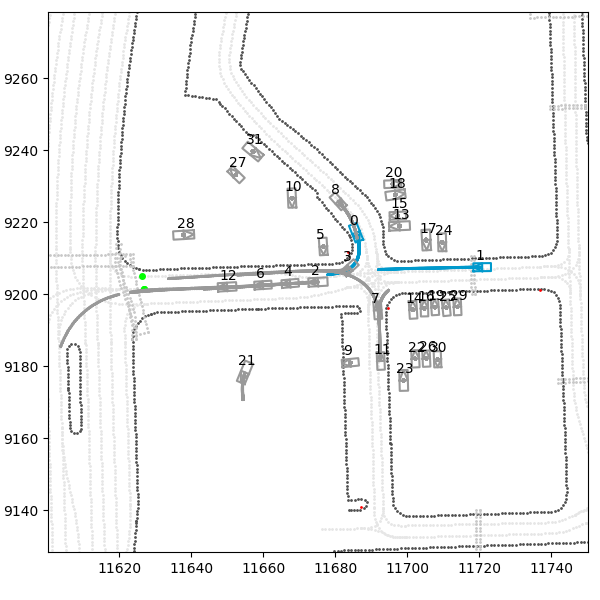

In [31]:
scenario_id, scenario = data_iter.next()
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)

In [32]:
is_ctrl = np.zeros(32, dtype=bool)
is_ctrl[0] = True
t= 11

37
torch.Size([1, 400])
torch.Size([1, 400])
best tensor(5.9857, device='cuda:0', grad_fn=<DivBackward0>)
{'layer0_loss': 5.983018398284912, 'layer1_loss': 5.988394260406494, 'loss_total': 5.985706329345703}


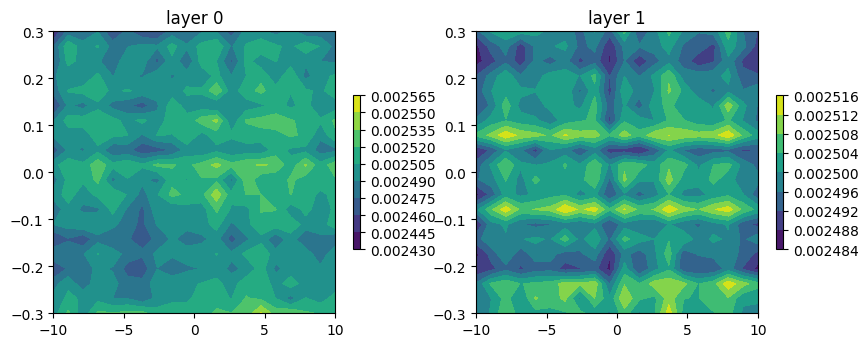

In [99]:

print(t)
input = process_input(
    scenario,
    is_ctrl,
    from_gt=True,
    current_time_index=t,
    hide_history=11
    )
gt_action = np.asarray(
    compute_inverse(scenario.log_trajectory, t, estimate_yaw_with_velocity=False).data[is_ctrl]
)
input['gt_action'] = gt_action
batch = merge_dict([input], 'cuda')


BC.zero_grad()
encoder_output = BC.encoder(batch, retain_input=True)
decoder_output = BC.decoder(encoder_output)
total_loss_best, tb_dict_best = BC.decoder.get_loss(decoder_output, debug = True)
# total_loss_best, tb_dict_best = BC.decoder.get_loss_best(decoder_output, debug = True)
# total_loss_gmm, tb_dict_gmm = BC.decoder.get_loss_gmm(decoder_output)


print('best', total_loss_best)
print(tb_dict_best)

# print('gmm', total_loss_gmm)
# print(tb_dict_gmm)

t+=1